In [1]:
import matplotlib.pyplot as plt
import time
from solvers import *

In [2]:
n = 100
m = 100
density = 0.1  # Probability of observing each entry

# seed
seed = int(time.time())

# Generate synthetic problem
X_true, X_obs, mask, u_true, v_true = generate_synthetic_problem(m, n, density, seed-1) # seed-1 to avoid overlap with the gaussian initialization seed as they'd be the same otherwise


In [3]:
from sklearn.decomposition import TruncatedSVD

def compare_solvers(X_obs, X_true, u0, v0, mask, lambda_r = 0.403, plot=False):
    """
    Compare the performance of Alternating Optimization (AO), AO with normalization and Gradient Descent.

    :param X_obs: Incomplete matrix (n x n), missing entries as zeros
    :param X_true: Ground truth matrix (n x n)
    :param u0: Initial guess for vector u (n,).
    :param v0: Initial guess for vector v (n,).
    :param mask: Binary mask of observed entries (n x n), dtype=bool
    :param lambda_r: Regularization strength
    :param plot: If True, plot residual curves
    """

    print("=== Alternating Optimization (AO) ===")
    start = time.time()
    u, v, it, res, hist = alternating_optimization(
        X_obs, mask, u0.copy(), v=v0.copy(), max_it=200,
        lambda_reg=lambda_r, verbose=False, track_residuals=plot
    )
    end = time.time()
    ao_sol = np.outer(u, v)
    observed_error_ao = np.linalg.norm((ao_sol - X_true) * mask, 'fro')
    full_error_ao = np.linalg.norm(ao_sol - X_true, 'fro')
    print(
        f"AO: Residual={res:.4f}, Observed Error={observed_error_ao:.6f}, Full Error={full_error_ao:.6f}, Iter={it}, Time={end - start:.4f}s")

    print("\n=== AO with Normalization (AON) ===")
    start = time.time()
    u, v, it, res, hist2 = alternating_optimization(
        X_obs, mask, u0.copy(), v=v0.copy(), max_it=200,
        lambda_reg=1.5e-2, norm_v=True, verbose=False, track_residuals=plot
    )
    end = time.time()
    aon_sol = np.outer(u, v)
    observed_error_aon = np.linalg.norm((aon_sol - X_true) * mask, 'fro')
    full_error_aon = np.linalg.norm(aon_sol - X_true, 'fro')
    print(
        f"AON: Residual={res:.4f}, Observed Error={observed_error_aon:.6f}, Full Error={full_error_aon:.6f}, Iter={it}, Time={end - start:.4f}s")

    print("\n=== Gradient Descent (GD) ===")
    lr = 9.41e-04
    lambda_gd = 6.95e-05
    start = time.time()
    u, v, it, res, hist3 = gradient_descent_rank1(
        X_obs, mask, u_init=u0.copy(), v_init=v0.copy(),
        max_it=1500, lr=lr, lambda_reg=lambda_gd,
        tol=1e-8, verbose=False, track_residuals=plot
    )
    end = time.time()
    gd_sol = np.outer(u, v)
    observed_error_gd = np.linalg.norm((gd_sol - X_true) * mask, 'fro')
    full_error_gd = np.linalg.norm(gd_sol - X_true, 'fro')
    print(
        f"GD: Residual={res:.4f}, Observed Error={observed_error_gd:.6f}, Full Error={full_error_gd:.6f}, Iter={it}, Time={end - start:.4f}s")

    # Plot residuals if available
    if plot:
        plt.figure(figsize=(10, 6))
        if hist and hist['objective']:
            plt.plot(hist['objective'], label='AO Observed Error')
        if hist2 and hist2['objective']:
            plt.plot(hist2['objective'], label='AON Observed Error')
        if hist3:
            plt.plot(hist3, label='GD Observed Error')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Frobenius Error on Observed Entries')
        plt.title('Convergence Comparison')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot the residuals
        plt.figure(figsize=(10, 6))
        if hist and hist['residuals']:
            plt.plot(hist['residuals'], label='AO Residuals')
        if hist2 and hist2['residuals']:
            plt.plot(hist2['residuals'], label='AON Residuals')
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Residual')
        plt.title('Residuals Comparison')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Baseline using Truncated SVD with imputed values
print("\n=== Truncated SVD ===")
X_filled = X_obs.copy()
X_filled[~mask] = X_obs[mask].mean()  # mean imputation
start = time.time()
svd = TruncatedSVD(n_components=1)
U = svd.fit_transform(X_filled)
V = svd.components_
svd_sol = U @ V
end = time.time()
observed_error_svd = np.linalg.norm((svd_sol - X_true) * mask, 'fro')
full_error_svd = np.linalg.norm(svd_sol - X_true, 'fro')
print(f"SVD: Observed Error={observed_error_svd:.6f}, Full Error={full_error_svd:.6f}, Time={end - start:.4f}s")



=== Truncated SVD ===
SVD: Observed Error=26.483936, Full Error=96.923466, Time=0.0000s


=== Gaussian Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=1.8933, Observed Error=1.893333, Full Error=16.250887, Iter=147, Time=0.1968s

=== AO with Normalization (AON) ===
AON: Residual=12.2868, Observed Error=12.286849, Full Error=188.274223, Iter=9, Time=0.0114s

=== Gradient Descent (GD) ===
GD: Residual=341.8466, Observed Error=18.487025, Full Error=119.695649, Iter=1500, Time=0.0477s


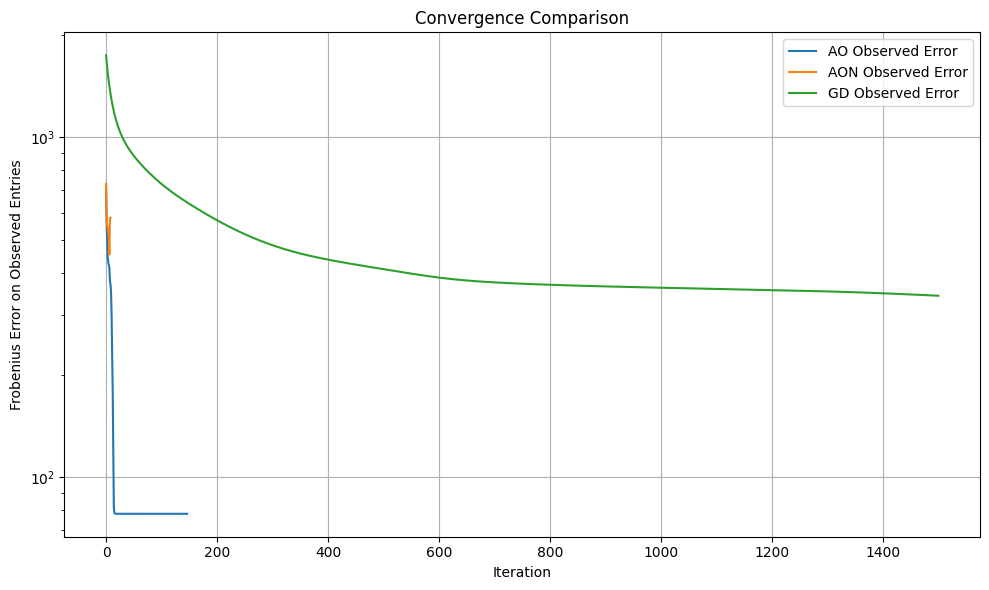

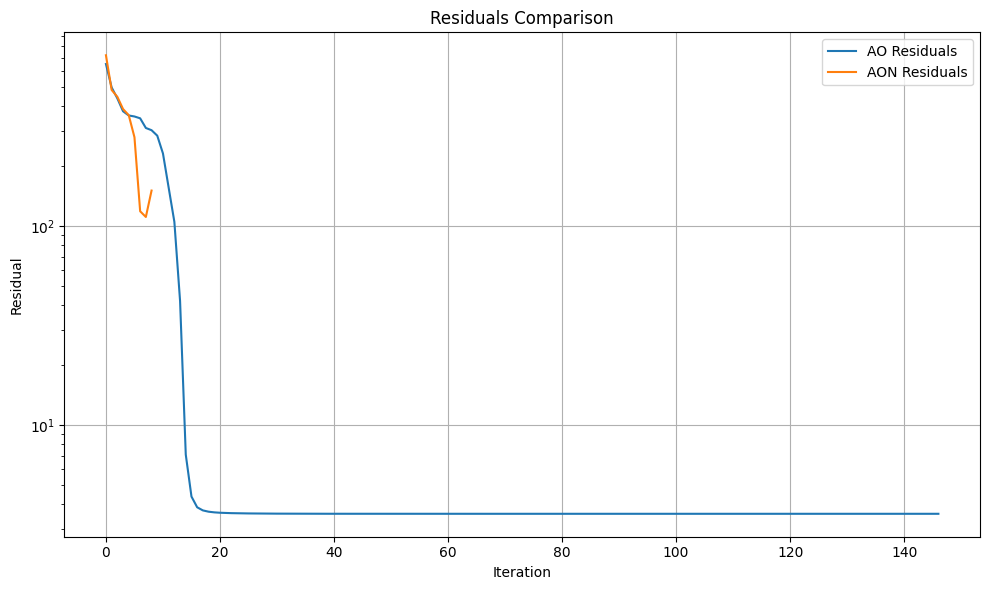

In [4]:
# Benchmark the different initialization strategies
print("=== Gaussian Initialization ===")
u0_g, v0_g = initialize_uv(X_obs, mask, strategy='gaussian', seed=seed)
# Benchmark the different solvers
compare_solvers(X_obs, X_true, u0_g.copy(), v0_g.copy(), mask, plot=True)


=== SVD Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=1.8278, Observed Error=1.827775, Full Error=16.101806, Iter=12, Time=0.0091s

=== AO with Normalization (AON) ===
AON: Residual=8.2684, Observed Error=8.268448, Full Error=38.822883, Iter=2, Time=0.0105s

=== Gradient Descent (GD) ===
GD: Residual=0.1894, Observed Error=0.418387, Full Error=7.220448, Iter=1500, Time=0.0427s


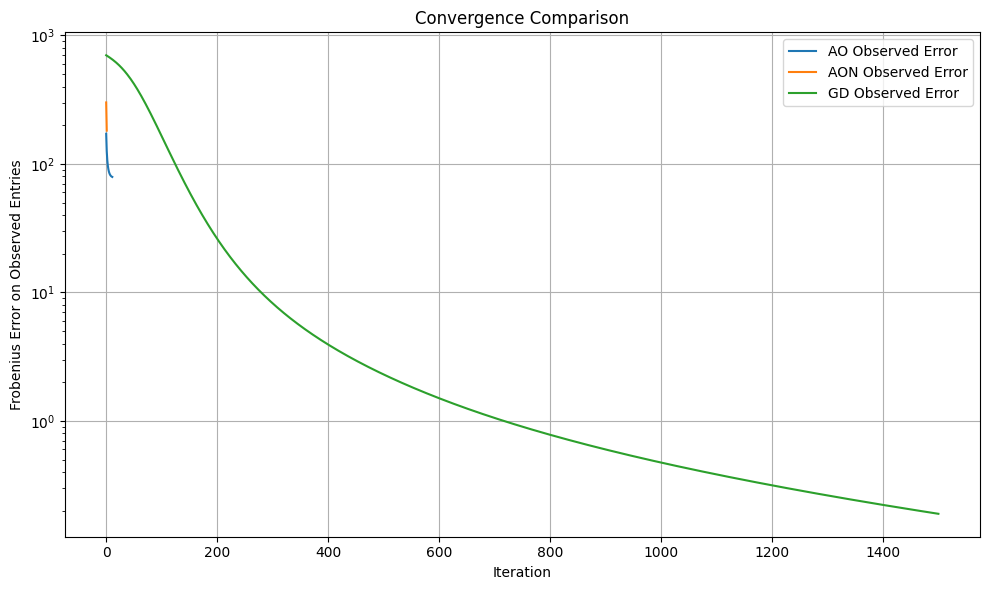

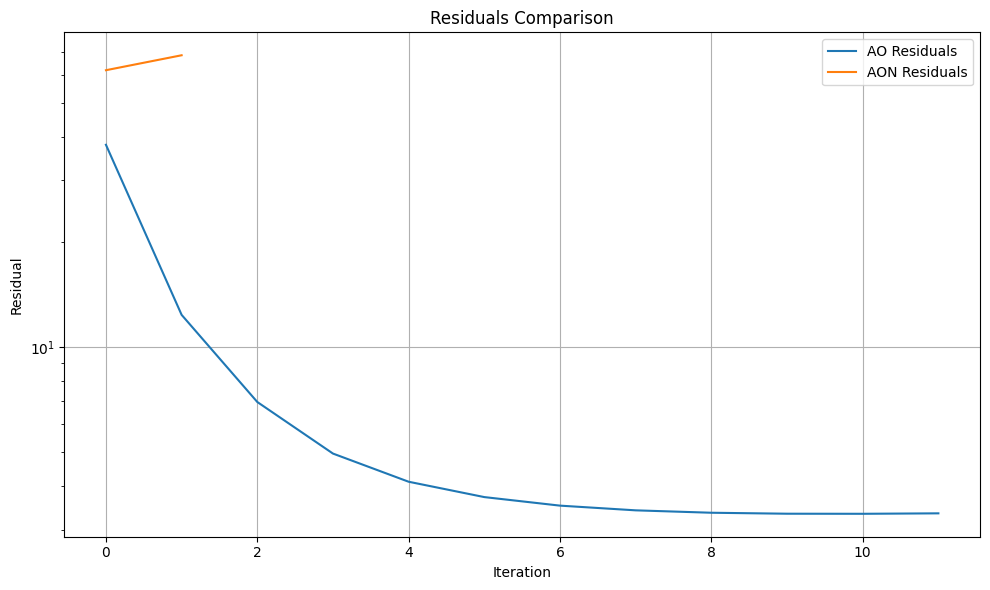

In [5]:
print("\n=== SVD Initialization ===")
u0_s, v0_s = initialize_uv(X_obs, mask, strategy='svd', seed=seed)
compare_solvers(X_obs, X_true, u0_s.copy(), v0_s.copy(), mask, plot=True)


=== SVD + Noise Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=1.8259, Observed Error=1.825927, Full Error=16.109007, Iter=11, Time=0.0181s

=== AO with Normalization (AON) ===
AON: Residual=3.7955, Observed Error=3.795451, Full Error=22.157460, Iter=47, Time=0.0608s

=== Gradient Descent (GD) ===
GD: Residual=0.2128, Observed Error=0.445407, Full Error=7.697287, Iter=1500, Time=0.0400s


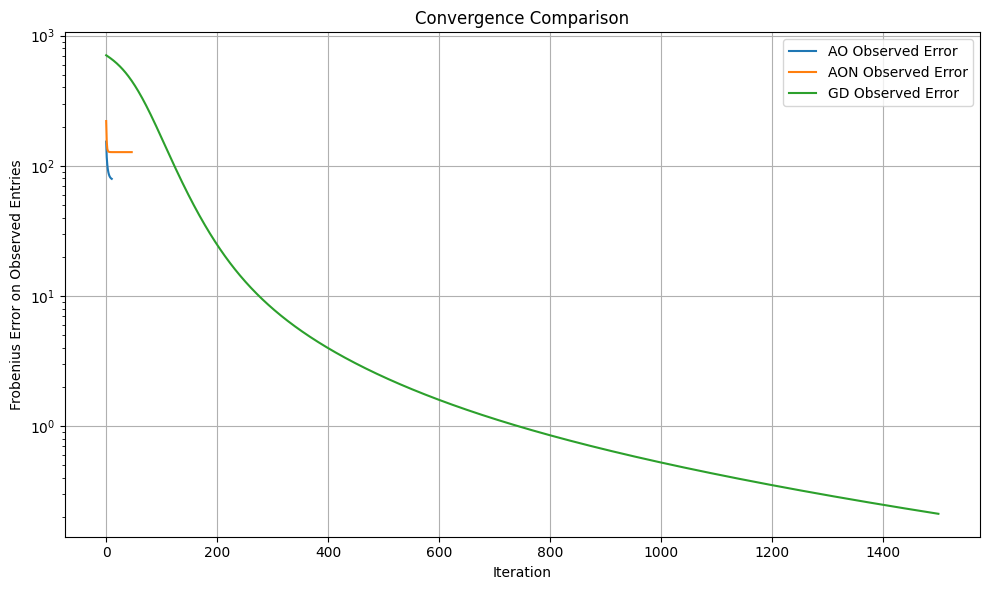

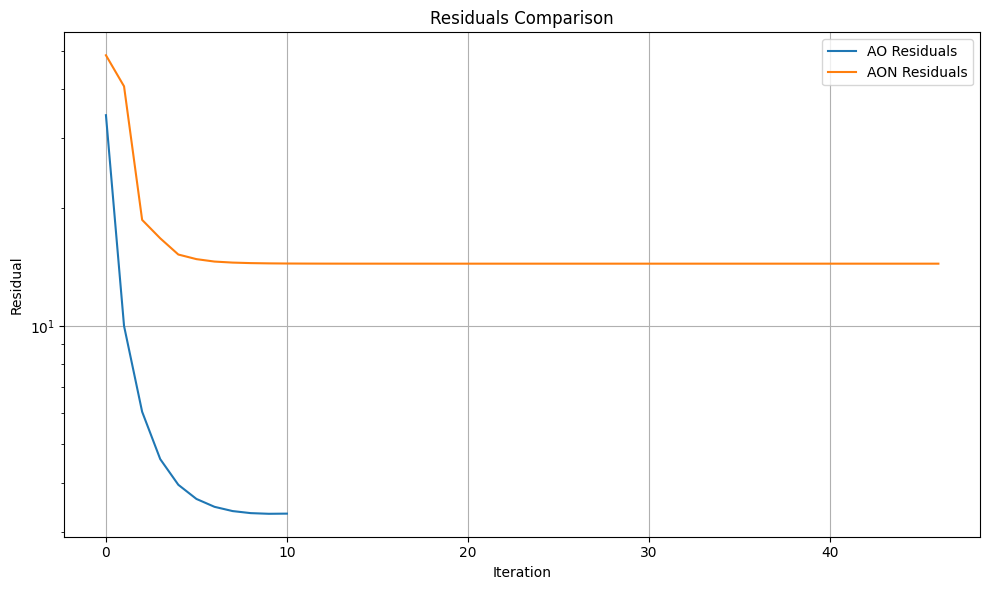

In [6]:
print("\n=== SVD + Noise Initialization ===")
u0_sn, v0_sn = initialize_uv(X_obs, mask, strategy='svd', epsilon=0.1, seed=seed)
compare_solvers(X_obs, X_true, u0_sn.copy(), v0_sn.copy(), mask, plot=True)


=== Mean Initialization ===
=== Alternating Optimization (AO) ===
AO: Residual=1.8933, Observed Error=1.893333, Full Error=16.250887, Iter=153, Time=0.2143s

=== AO with Normalization (AON) ===
AON: Residual=9.3790, Observed Error=9.378994, Full Error=128.823078, Iter=7, Time=0.0092s

=== Gradient Descent (GD) ===
GD: Residual=175.3861, Observed Error=13.234126, Full Error=123.639809, Iter=1500, Time=0.0421s


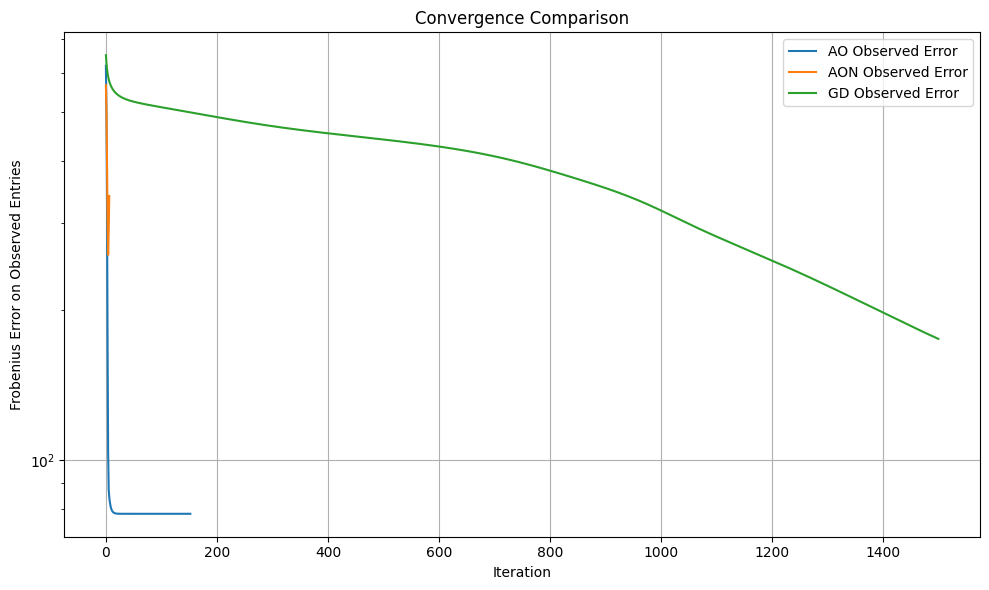

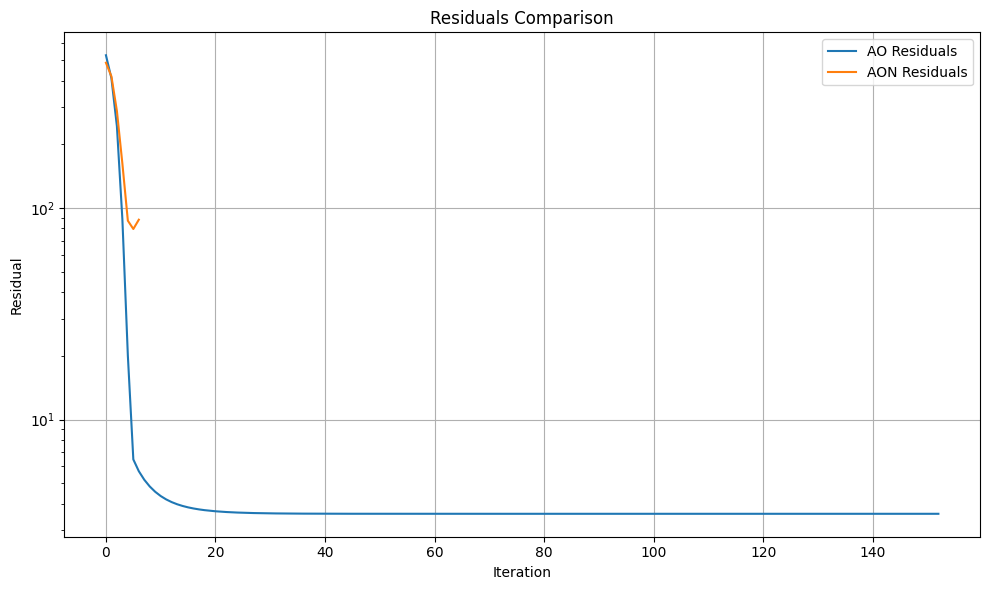

In [7]:
print("\n=== Mean Initialization ===")
u0_m, v0_m = initialize_uv(X_obs, mask, strategy='mean', seed=seed)
compare_solvers(X_obs, X_true, u0_m.copy(), v0_m.copy(), mask, plot=True)